# MNIST DP-SGD Keras

## Imports (and Google Drive Mount in Google Colab)

In [1]:
"""Evaluate the DP-SGD optimizer using TF 1.x."""
import numpy as np
import pandas as pd
# Give me the whole data frame in the output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from timeit import default_timer as timer

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns
sns.set()

# Set tensorlfow version in google colab
try:
  %tensorflow_version 1.x
except Exception:
  pass
import tensorflow.compat.v1 as tf

# Used to measure the privacy gurantee
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import \
    get_privacy_spent

# Optimizer used for the privacy-preserving training
from tensorflow_privacy.privacy.optimizers.dp_optimizer import \
    DPGradientDescentGaussianOptimizer

GradientDescentOptimizer = tf.train.GradientDescentOptimizer

# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

## Function Definitions

### Compute Privacy Budget for given Hyperparameters

In [2]:
def compute_epsilon(noise_multiplier, batch_size, target_delta,
                    trainingsset_size,
                    orders=[1 + x / 10. for x in range(1, 100)]
                    + list(range(12, 64))):
  """Computes epsilon values for given hyperparameters.

      Epsilon describes the strength of our privacy guarantee. In the case of
      DP-ML, it gives a bound on how much the probability of a particular model
      output can vary by including (or removing) a single training example. We
      usually want it to be a small constant. However, this is only an upper
      bound, and a large value of epsilon could still mean good practical
      privacy. Interpreting this value could be quiet difficult.

  Returns
  -------
  float
      Epsion-value for the expanded privacy budget.

  Parameters
  ----------
  noise_multiplier : numpy.ndarray
      Parameter to control how much noise is sampled and added to gradients
      before they are applied by the optimizer.
  batch_size : int
      Number of samples used in each training step.
  target_delta : float
      Delta bounds the probability of our privacy guarantee not holding. A rule
      of thumb is to set it to be less than the inverse of the training data
      size (i.e., the population size).
  trainingsset_size : int
      Number of samples in the trainingset.
  orders : list, optional
      List of orders, at which the Renyi divergence will be computed. If you
      are targeting a particular range of epsilons (say, 1—10) and your delta
      is fixed (say, 10^-5), then your orders must cover the range between
      1+ln(1/delta)/10=2.15 and 1+ln(1/delta)/1=12.5. The default orders are
      suitable for the mnist dataset.
  """
  # Together with the noise multiplier are these the parameters which are
  # relevant to measuring the potential privacy loss induced by the training.
  # being included in a minibatch.
  #
  # Number of steps the optimizer takes in each epoch.
  steps_per_epoch = trainingsset_size // batch_size
  #
  # The probability of an individual training point to be sampled in a
  # minibatch.
  sampling_probability = batch_size / trainingsset_size

  # List of epsilons per epoch.
  epsilon_progression = []

  rdp = 0.0

  for nm in noise_multiplier:
      if nm == 0.0:
          rdp = float('inf')
      rdp = rdp + compute_rdp(q=sampling_probability,
                              noise_multiplier=nm,
                              steps=steps_per_epoch,
                              orders=orders)
      epsilon = get_privacy_spent(orders, rdp, target_delta=target_delta)[0]
      epsilon_progression.append(epsilon)

  return epsilon_progression

### Load and Preprocess MNIST Dataset

In [3]:
def load_mnist(dataset='mnist'):
  """Loads and preprocesses the MNIST dataset.

  Returns
  -------
  tuple
      (training data, training labels, test data, test labels)
  """
  
  train, test = tf.keras.datasets.mnist.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
  test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

  train_labels = np.array(train_labels, dtype=np.int32)
  test_labels = np.array(test_labels, dtype=np.int32)

  train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
  test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

  return train_data, train_labels, test_data, test_labels

### Create a simple CNN Model

In [4]:
def create_model():
  """Creates a simple example CNN.

  Returns
  -------
  tensorflow.python.keras.engine.sequential.Sequential
      A simple example CNN
  """
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Conv2D
  from tensorflow.keras.layers import MaxPool2D
  from tensorflow.keras.layers import Flatten
  from tensorflow.keras.layers import Dense

  model = Sequential()
  model.add(Conv2D(16, 8, strides=2, padding='same', activation='relu',
                   input_shape=(28, 28, 1)))
  model.add(MaxPool2D(2, 1))
  model.add(Conv2D(32, 4, strides=2, padding='valid', activation='relu'))
  model.add(MaxPool2D(2, 1))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(10))

  return model

### Define and Train Model (SGD or DP-SGD alias Noisy-SGD)

In [5]:
def train_model(train_data, train_labels, test_data, test_labels, dpsgd,
                learning_rate, noise_multiplier, l2_norm_clip, batch_size,
                epochs, microbatches, callbacks=None, verbose=1):
  """Define, train and compute the used privacy budget of the keras model.

  Raises
  ------
  ValueError
      The number of microbatches must divide the batch size.

  Parameters
  ----------
  train_data : numpy.ndarray
      Array of training datapoints.
  train_labels : numpy.ndarry
      Array of labels for the training datapoints (one-hot encodding).
  test_data : numpy.ndarray
      Array of test datapoints.
  test_labels : numpy.ndarray
      Array of labels for the test datapoints (one-hot encodding).
  dpsgd : bool
      If True, train with DP-SGD. If False, train with vanilla SGD.
  learning_rate : float
      Learning rate for training.
  noise_multiplier : float
      Ratio of the standard deviation to the clipping norm. Typically more
      noise results in stronger privacy and often at the expense of utility.
  l2_norm_clip : float
      Attribute gives the maximum Euclidean norm of each individual gradient
      that is computed on an individual training example from a minibatch. This
      parameter is used to bound the optimizer's sensitivity to individual
      training points.
  batch_size : int
      Number of samples used in each training step.
  epochs : int
      Number of epochs used for the training.
  microbatches : int
      Number of microbatches (must be evently divide batch size). In practice
      clipping gradients for each exampe indivdudally can strongly degrade the
      performance because instead of parallelizing at the granularity of
      batch_size the computations must be performed for each example. Rather
      than clipping gradients per example we clip them on the basis of
      microbatches. In this way is the number of microbatches a trade-off
      parameter between privacy and utility (small number -> higher privacy,
      number closer to size of minibatches -> higher utility).
  callbacks : list, optional
      Callbacks allow to customize the behaviour of a model during training,
      evaluation and inference. Be careful, most callbacks do not work with the
      DP optimizers. Alternatively you can develop your own callbacks.
  verbose : int, optional
      Verbose parameter of the TF fit function.

  Returns
  -------
  tuple
      Training history, training time, epsilon value (see compute_epsilon())
  """
  if dpsgd and batch_size % microbatches != 0:
    raise ValueError('Number of microbatches should divide evenly size of'
                     + 'batch_size')

  if dpsgd and (len(train_data) % batch_size != 0
                or len(test_data) % batch_size != 0):
    raise ValueError('Size of minibatches should divide evenly size of'
                     + 'training- and testdatasets.')

  model = create_model()

  if dpsgd:
    optimizer = DPGradientDescentGaussianOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=microbatches,
        learning_rate=learning_rate)
    # Compute vector of per-example loss rather than its mean over a minibatch.
    # The optimizers needs the loss per example in order to compute the
    # gradients per example (rather than per minibatch) and clip/noise the
    # gradient of each example individually.
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, reduction=tf.losses.Reduction.NONE)
  else:
    optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  history = model.fit(train_data, train_labels,
                      epochs=epochs,
                      validation_data=(test_data, test_labels),
                      batch_size=batch_size,
                      verbose=verbose,
                      callbacks=callbacks)

  return model, history

### Evaluate a Model

In [6]:
def model_eval(model, x, y):
  """model.evaluate() does not work with DP-Optimizer in this simple setting.
  Use this function instead.

  Parameters
  ----------
  model : tensorflow.python.keras.engine.sequential.Sequential
      The model to be evaluated.
  x : np.ndarray
      Datapoints for the evaluation.
  y : np.ndarray
      Labels to the datapoints in x.

  Returns
  -------
  float
      Accuracy of the model on the given datapoints and labels.
  """
  correct_preds = np.sum(np.argmax(model.predict(x), axis=1)
                                    == np.argmax(y, axis=1))
  return correct_preds / len(x)

## Fit a Model

### Define Callbacks and Hyperparameter

In [7]:
# --- Callbacks

# - TF Callbacks
# * ModelCheckpoint does not work with TF-Privacy
# * TensorBoard does not work as simple callback with TF-Privacy, to get
#   TensorBoard running in TF1.x use profile_batch=0 ()

# - Custom Callbacks
import time


class RunTimeHistory(tf.keras.callbacks.Callback):
  """Callback to make runtime measuremnts.

  Attributes
  ----------
  epoch_time_start : float
      Time at the beginning of the current epoch.
  times : list
      Training time for each epoch.
  """
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, batch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, batch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)


class EarlyStopping(tf.keras.callbacks.Callback):
  """Callback to stop training when the loss is at its min, i.e.
  the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

  def __init__(self, patience=0):
    self.patience = patience

    # best_weights to store the weights at which the min loss occurs.
    self.best_weights = None

  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is not minimum
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best = np.inf

  def on_epoch_end(self, epoch, logs=None):
    current = np.mean(logs.get('loss'))
    if np.less(current, self.best):
      self.best = current
      self.wait = 0
      # Record the best weights if current results is better (less).
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if self.wait > self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))
      print('Restoring model weights from the end of the best epoch.')
      self.model.set_weights(self.best_weights)


# TODO: Write custom callback for model checkpointing
# TODO: Write custom callback that stopps training after x minutes
# TODO: Write custom callback for (dynamic) learning rate decay
# TODO: Write custom callback to adjust hyperparameters during training

# - Selected Callbacks
runtime_history = RunTimeHistory()
early_stopping = EarlyStopping()
callbacks = [runtime_history]

# --- Hyperparamater
dpsgd = False
learning_rate = 0.15
noise_multiplier = 1.1
l2_norm_clip = 1.0
# For the DP Optimizer the size of the minibatches must divide the number of
# training samples!
batch_size = 100
epochs = 20
# For the DP Optimizer the size of the microbatches must divide the size of the
# batch_size!
microbatches = 100
verbose=1

In [8]:
# Load training and test data.
train_data, train_labels, test_data, test_labels = load_mnist()

# Train the keras model and compute the used privacy budget.
model, history = train_model(train_data, train_labels, test_data, test_labels, dpsgd,
                             learning_rate, noise_multiplier, l2_norm_clip,
                             batch_size, epochs, microbatches, callbacks)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 79us/sample - loss: 0.3194 - acc: 0.8969 - val_loss: 0.0626 - val_acc: 0.9812
Epoch 2/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0703 - acc: 0.9782 - val_loss: 0.0432 - val_acc: 0.9869
Epoch 3/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0510 - acc: 0.9839 - val_loss: 0.0384 - val_acc: 0.9883
Epoch 4/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0404 - acc: 0.9876 - val_loss: 0.0500 - val_acc: 0.9840
Epoch 5/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0338 - acc: 0.9893 - val_loss: 0.0346 - val_acc: 0.9891
Epoch 6/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0288 - acc: 0.9912 - val_loss: 0.0346 - val_acc: 0.9894
Epoch 7/20
60000/60000 [===========

## Privacy Evaluation (only if dpsgd)

In [9]:
noise_multipliers = epochs * [noise_multiplier]
# Rule of thump: Delta is set to 1e-5 because MNIST has 60000 training
# points (see the walktrough). Delta bounds the probability that our privacy
# guarantee do not hold.
target_delta = 1e-5
# Compute the privacy budget expended
epsilon_progression = compute_epsilon(noise_multipliers, batch_size,
                                      target_delta, len(train_data))

## Collect everything potentially interesting in a dataframe
(In truth, there is a lot more interesting data produced during the training... Maybe you can find some more interesting insights yourself...)

Let's save for each epoch:
* loss
* validation loss
* accuracy
* validation accuracy
* learning rate
* noise multiplier
* l2 norm clip
* epsilon value
* runtime

In [10]:
# If we use the DP-Optimizer the history object contains the loss value for
# each minibatch in an epoch. To obtain the loss for the entire epoch, we
# calculate the average of these values.
loss = [np.mean(l) for l in history.history['loss']]
val_loss = [np.mean(l) for l in history.history['val_loss']]

# Currently we do not change the learning rate, the noise multiplier or the
# clipping threshold during the training. We store the same value for each
# epoch.
learning_rates = epochs * [learning_rate]
microbatches 
noise_multipliers = epochs * [noise_multiplier] if dpsgd else epochs * [np.nan]
l2_norm_clips = epochs * [l2_norm_clip] if dpsgd else epochs * [np.nan]
epsilon_progression = epsilon_progression if dpsgd else epochs * [np.nan]
target_deltas = epochs * [target_delta]
microbatchess = epochs * [microbatches]
batch_sizes = epochs * [batch_size]
epoch_nrs = list(range(epochs))

data = {'loss': loss,
        'val_loss': val_loss,
        'accuracy': history.history['acc'],
        'val_accuracy': history.history['val_acc'],
        'learning_rate': learning_rates,
        'noise_multiplier': noise_multipliers,
        'l2_norm_clip': l2_norm_clips,
        'epsilon': epsilon_progression,
        'runtime': runtime_history.times,
        'target_delta': target_deltas,
        'microbatchess': microbatches,
        'batch_sizes': batch_sizes,
        'epoch_nrs': epoch_nrs}

data = pd.DataFrame(data)

data

,loss,val_loss,accuracy,val_accuracy,learning_rate,noise_multiplier,l2_norm_clip,epsilon,runtime,target_delta,microbatchess,batch_sizes,epoch_nrs
0,0.319387,0.062648,0.896900,0.9812,0.15,NaN,NaN,NaN,4.759001,0.00001,100,100,0
1,0.070267,0.043158,0.978183,0.9869,0.15,NaN,NaN,NaN,2.354058,0.00001,100,100,1
2,0.050990,0.038424,0.983850,0.9883,0.15,NaN,NaN,NaN,2.323475,0.00001,100,100,2
3,0.040355,0.049976,0.987550,0.9840,0.15,NaN,NaN,NaN,2.311299,0.00001,100,100,3
4,0.033817,0.034560,0.989300,0.9891,0.15,NaN,NaN,NaN,2.291595,0.00001,100,100,4
5,0.028801,0.034639,0.991167,0.9894,0.15,NaN,NaN,NaN,2.291098,0.00001,100,100,5
6,0.025665,0.029436,0.991917,0.9903,0.15,NaN,NaN,NaN,2.322583,0.00001,100,100,6
7,0.021737,0.063638,0.992967,0.9808,0.15,NaN,NaN,NaN,2.326858,0.00001,100,100,7
8,0.020392,0.031825,0.993600,0.9891,0.15,NaN,NaN,NaN,2.313331,0.00001,100,100,8
9,0.017604,0.029588,0.994333,0.9905,0.15,NaN,NaN,NaN,2.309435,0.00001,100,100,9


## Evaluate DP-SGD or Hyperparameter-Search
The following code is intended to let you experiment with different combinations of hyperparameters. To do so, you need to fill the lists with your hyperparameter values, as in the example. For the ```noise_multiplier``` and ```clipping_threshold```, you only need to enter values when the DP Optimizer is selected. With the parameter ```runs``` you can set how often you want to repeat the experiment with the same hyperparameter combination. Be warned though, the DP Optimizer is considerably slower than the normal Optimizer!

### Run Experiments

In [11]:
# If true, the DP-Optimizer is used
dpsgds = [False, True]
learning_rates = 2 * [0.1]
noise_multipliers = 2 * [1.5]
l2_norm_clips = 2 * [1.0]
batch_size = 2 * [250]
microbatches = 2 * [50]
epochs = 2 * [20]
target_delta = 1e-5
runs = 1
verbose = 3

In [ ]:
# List of dataframes; One dataframe per run
data = []
dp_idx = -1
for idx, dp in enumerate(dpsgds):
  dp_idx = dp_idx + 1 if dp else dp_idx
  for run in range(runs):
    print('\n')
    print('Experiment:', idx, '/', len(dpsgds), 'Run: ', run+1, '/', runs)
    model, history = train_model(train_data, train_labels, test_data, test_labels, dp,
                                 learning_rates[idx], noise_multipliers[dp_idx], l2_norm_clips[dp_idx],
                                 batch_size[idx], epochs[idx], microbatches[idx], callbacks, verbose)
    
    loss = [np.mean(l) for l in history.history['loss']]
    val_loss = [np.mean(l) for l in history.history['val_loss']]
    
    learning_rates_per_epoch = epochs[idx] * [learning_rates[idx]]
    target_deltas = epochs[idx] * [target_delta]
    microbatches_per_epoch = epochs[idx] * [microbatches[idx]]
    batch_size_per_epoch = epochs[idx] * [batch_size[idx]]
    epoch_nrs = list(range(epochs[idx]))
    
    noise_multipliers_per_epoch = []
    l2_norm_clips_per_epoch = []
    if dp:
      noise_multipliers_per_epoch = epochs[idx] * [noise_multipliers[dp_idx]]
      l2_norm_clips_per_epoch = epochs[idx] * [l2_norm_clips[dp_idx]]
      epsilon_progression = compute_epsilon(noise_multipliers_per_epoch, batch_size[idx],
                                          target_delta, len(train_data))
    else:
      noise_multipliers_per_epoch = epochs[idx] * [np.nan]
      l2_norm_clips_per_epoch = epochs[idx] * [np.nan]
      epsilon_progression = epochs[idx] * [np.nan]
    
    
    run_data = ({'experiment_nr': idx,
                 'run_nr': run,
                 'loss': loss,
                 'val_loss': val_loss,
                 'accuracy': history.history['acc'],
                 'val_accuracy': history.history['val_acc'],
                 'learning_rate': learning_rates_per_epoch,
                 'noise_multiplier': noise_multipliers_per_epoch,
                 'l2_norm_clip': l2_norm_clips_per_epoch,
                 'epsilon': epsilon_progression,
                 'runtime': runtime_history.times,
                 'target_delta': target_deltas,
                 'microbatches': microbatches_per_epoch,
                 'batch_sizes': batch_size_per_epoch,
                 'epoch_nrs': epoch_nrs})
    
    run_data = pd.DataFrame(run_data)
    
    data.append(run_data)
    #print(run_data.to_string())
    
    data_df = pd.concat(data)
    data_df.to_pickle('data_exp' + str(idx) + '_run' + str(run) + '.pkl')

### Visualize Experiment Data
To better understand the results of our experiments we now want to visualize them. In the first step we grab our data frame and search and calculate the metrics we are interested in. In the second step we use Matplotlib to plot the results. You might have to adapt this part of the code if you do your own experiments or want to visualize the data in a different way.

In [ ]:
# Experiments performed:
# nr.  : description
# 00-00: 20 epochs over 3 runs, no dp 
# 01-11: 20 epochs over 3 runs, varying noise_muliplier (0.5-1.5)
# 12-17: 20 epochs over 3 runs, varying l2_norm_clip (1.0-1.5)
# 18-21: 20 epochs over 3 runs, varying microbatches (5, 10, 25, 50)
# 22-24: 20 epochs over 3 runs, varying batch_size (200, 100, 50),
#                               and same number of microbatches

# Unless stated differently, the following values were used:
# batch_size: 250
# microbatches: 250
# target_delta: 1e-5

In [14]:
# Grab the data we are interesed in
data_df = pd.read_pickle('data_exp00-24.pkl')
del data_df['run_nr']
# Another bug, this time in pandas: as_index=False does not work with aggregate()
data_df = data_df.groupby(['experiment_nr', 'epoch_nr']).aggregate(['mean', np.nanstd])
data_df.head()

loss            val_loss            accuracy  \
                            mean    nanstd      mean    nanstd      mean   
experiment_nr epoch_nr                                                     
0             0         0.583346  0.030557  0.122908  0.006724  0.816139   
              1         0.118994  0.003065  0.089362  0.009016  0.963383   
              2         0.084526  0.002642  0.064073  0.006740  0.973828   
              3         0.125374  0.099595  0.068105  0.025188  0.965239   
              4         0.070537  0.021129  0.058805  0.012131  0.978311   

                                 val_accuracy           learning_rate         \
                          nanstd         mean    nanstd          mean nanstd   
experiment_nr epoch_nr                                                         
0             0         0.011346  0.961000     0.002030  0.1           0.0     
              1         0.000967  0.971300     0.002234  0.1           0.0     
              2         0.000826  0.979367     0.002454  0.1           0.0     
              3         0.023922  0.978633     0.006982  0.1           0.0     
              4         0.005989  0.981300     0.003555  0.1           0.0     

                       noise_multiplier        l2_norm_clip        epsilon  \
                                   mean nanstd         mean nanstd    mean   
experiment_nr epoch_nr                                                       
0             0        NaN              NaN    NaN          NaN    NaN       
              1        NaN              NaN    NaN          NaN    NaN       
              2        NaN              NaN    NaN          NaN    NaN       
              3        NaN              NaN    NaN          NaN    NaN       
              4        NaN              NaN    NaN          NaN    NaN       

                                runtime           target_delta         \
                       nanstd      mean    nanstd         mean nanstd   
experiment_nr epoch_nr                                                  
0             0        NaN     1.238335  0.033704  0.00001      0.0     
              1        NaN     1.085478  0.022931  0.00001      0.0     
              2        NaN     1.078981  0.021445  0.00001      0.0     
              3        NaN     1.101853  0.019417  0.00001      0.0     
              4        NaN     1.077415  0.014638  0.00001      0.0     

                       microbatches        batch_size         
                               mean nanstd       mean nanstd  
experiment_nr epoch_nr                                        
0             0         250          0.0    250        0.0    
              1         250          0.0    250        0.0    
              2         250          0.0    250        0.0    
              3         250          0.0    250        0.0    
              4         250          0.0    250        0.0

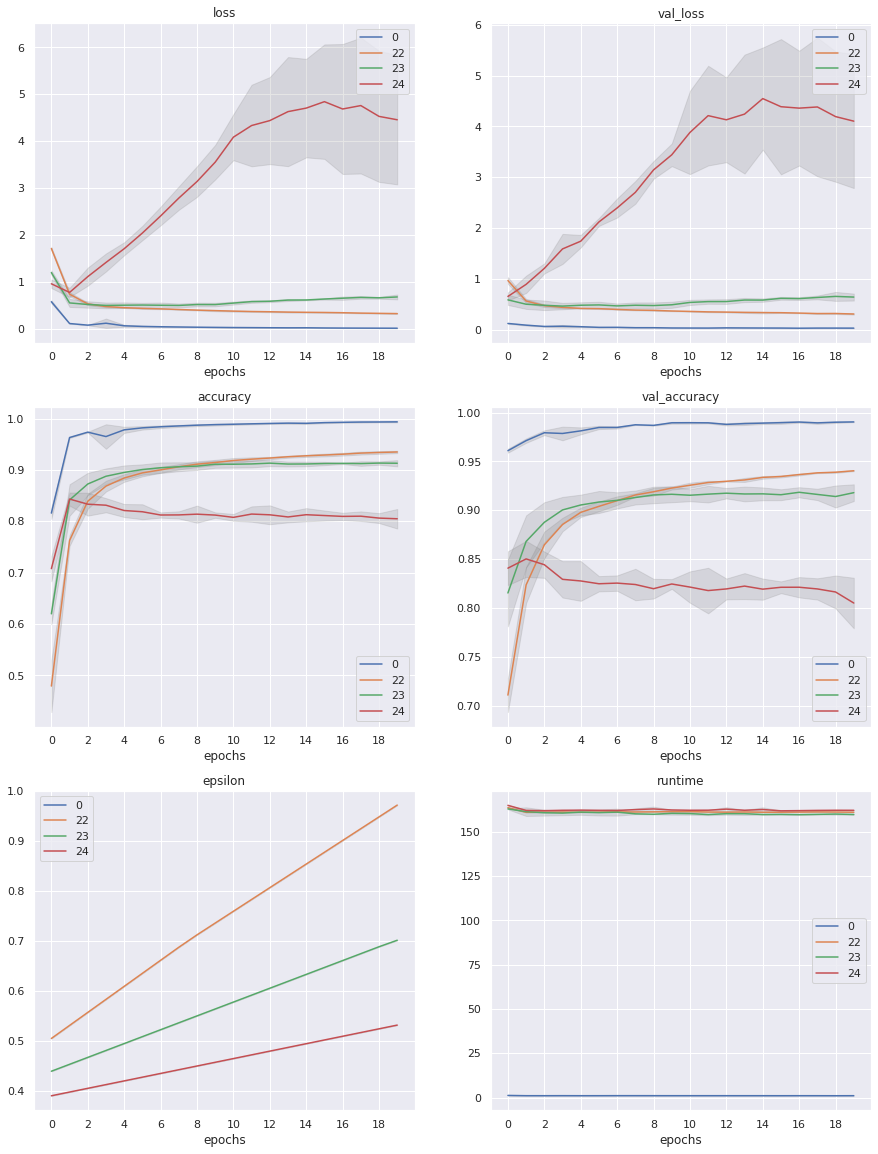

In [103]:
# Visualize our results (I'm sure this could be easier with Seaborn...)

# Select experiments for line-plot
experiments = [0] + list(range(22, 25))
# Select values to plot
values = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'epsilon', 'runtime']

fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Make one plot for each value
for i, idx in enumerate(values):
    ax = fig.add_subplot(3, 2, i+1)
    
    # Plot mean of the values
    mean = data_df.loc[experiments, idx].loc[:,'mean'].unstack(level=0)
    experiment_plot = ax.plot(mean)
    
    # Visualize the standard derivation of our results
    nanstd = data_df.loc[experiments, idx].loc[:,'nanstd'].unstack(level=0)
    for i in range(len(experiments)):
      x = list(mean) # number of epochs
      y = mean.to_numpy().T
      d = nanstd.to_numpy().T
      ax.fill_between(x, y[i] - d[i], y[i] + d[i], color='gray', alpha=0.2)
    
    # Make plot look better
    ax.legend(experiment_plot, experiments)
    ax.set(title=idx, xlabel='epochs')
    ax.xaxis.set_major_locator(plt.MultipleLocator(2))